### Source Images from Open Adobe Project
[Adobe Panoramas](https://liquidtelecom.dl.sourceforge.net/project/adobedatasets.adobe/adobe_panoramas.tgz)

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [2]:
# generating the necessary txt file to input for the super glue algorithm
img_name = 'hotel' # set of outdoor images
num_images = 8
with open('adobe_panorama.txt', 'w') as file:
    for i in range(num_images -1,0,-1):
        file.write("{img}-{:02}.png {img}-{:02}.png\n".format(i,i-1, img = img_name))

In [3]:
# Running the super glue algorithm on outdoor dataset to match features
!python match_pairs.py  --resize 1600 \
                        --superglue outdoor \
                        --max_keypoints 2048 \
                        --nms_radius 3 \
                        --resize_float \
                        --input_dir adobe_panorama/ \
                        --input_pairs adobe_panorama.txt \
                        --output_dir adobe_panorama/output \
                        --viz \
                        --keypoint_threshold 0.05 \
                        --match_threshold 0.9

Namespace(input_pairs='adobe_panorama.txt', input_dir='adobe_panorama/', output_dir='adobe_panorama/output', max_length=-1, resize=[1600], resize_float=True, superglue='outdoor', max_keypoints=2048, keypoint_threshold=0.05, nms_radius=3, sinkhorn_iterations=20, match_threshold=0.9, viz=True, eval=False, fast_viz=False, cache=False, show_keypoints=False, viz_extension='png', opencv_display=False, shuffle=False, force_cpu=False)
Will resize max dimension to 1600
Running inference on device "cuda"
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)
Looking for data in directory "adobe_panorama"
Will write matches to directory "adobe_panorama\output"
Will write visualization images to directory "adobe_panorama\output"
[Finished pair     0 of     7] load_image=0.038 matcher=1.524 viz_match=1.011 total=2.573 sec {0.4 FPS} 
[Finished pair     1 of     7] load_image=0.036 matcher=1.230 viz_match=0.993 total=2.259 sec {0.4 FPS} 
[Finished pair     2 of     7] load_image=0.035 mat

In [6]:
#generatig the npz files for extract matching information
npz_files = ["{img}-{:02}_{img}-{:02}_matches.npz".format(i,i-1, img = img_name) for i in range(num_images -1,0,-1)]
for file in npz_files:
    path = 'adobe_panorama/output/'+file
    npz = np.load(path)
print(npz.files)

['keypoints0', 'keypoints1', 'matches', 'match_confidence']


For each keypoint in `keypoints0`, the `matches` array indicates the index of the matching keypoint in `keypoints1`, or `-1` if the keypoint is unmatched.

```python
>>> import numpy as np
>>> path = 'dump_match_pairs/scene0711_00_frame-001680_scene0711_00_frame-001995_matches.npz'
>>> npz = np.load(path)
>>> npz.files
['keypoints0', 'keypoints1', 'matches', 'match_confidence']
>>> npz['keypoints0'].shape
(382, 2)
>>> npz['keypoints1'].shape
(391, 2)
>>> npz['matches'].shape
(382,)
>>> np.sum(npz['matches']>-1)
115
>>> npz['match_confidence'].shape
(382,)
```

In [7]:
# testing with one pair of images 
npz = np.load('adobe_panorama/output/'+npz_files[0])
npz.files
point_set1 = npz['keypoints0'][npz['matches']>-1]
matching_indexes =  npz['matches'][npz['matches']>-1] # -1 if the keypoint is unmatched
point_set2 = npz['keypoints1'][matching_indexes]
print("Number of matching points for the findHomography algorithm:")
print("In left image:", len(point_set1),"\nIn right image:", len(point_set2))

Number of matching points for the findHomography algorithm:
In left image: 173 
In right image: 173


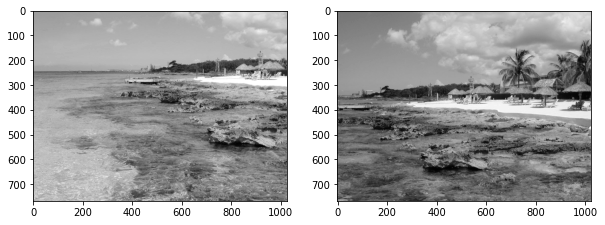

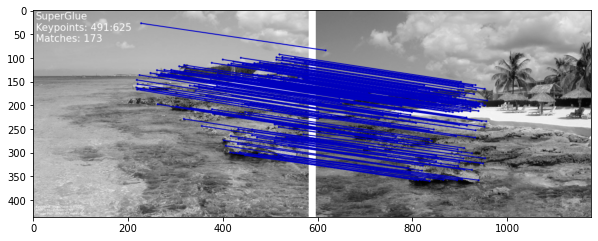

In [32]:
im_left = cv.imread('adobe_panorama/hotel-07.png',cv.IMREAD_ANYCOLOR)
im_right = cv.imread('adobe_panorama/hotel-06.png',cv.IMREAD_ANYCOLOR)
fig = plt.figure(figsize = (10,10))
plt.subplot(121),plt.imshow(im_left, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(122),plt.imshow(im_right, cmap='gray', vmin = 0, vmax = 255)
plt.figure(figsize=(10,10))
matched_points = cv.imread('adobe_panorama/output/hotel-07_hotel-06_matches.png',cv.IMREAD_ANYCOLOR)
plt.imshow(matched_points, cmap='gray', vmin = 0, vmax = 255)
plt.show()

[[ 1.12415090e+00 -6.67600929e-03 -6.63306808e+02]
 [ 3.40942817e-02  1.05866631e+00  1.43395175e+02]
 [ 8.86563449e-05 -3.29263756e-05  1.00000000e+00]]


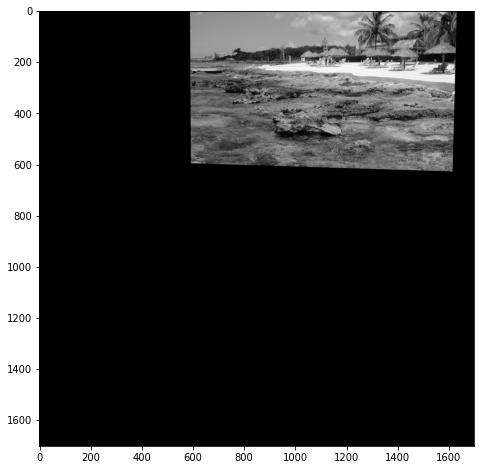

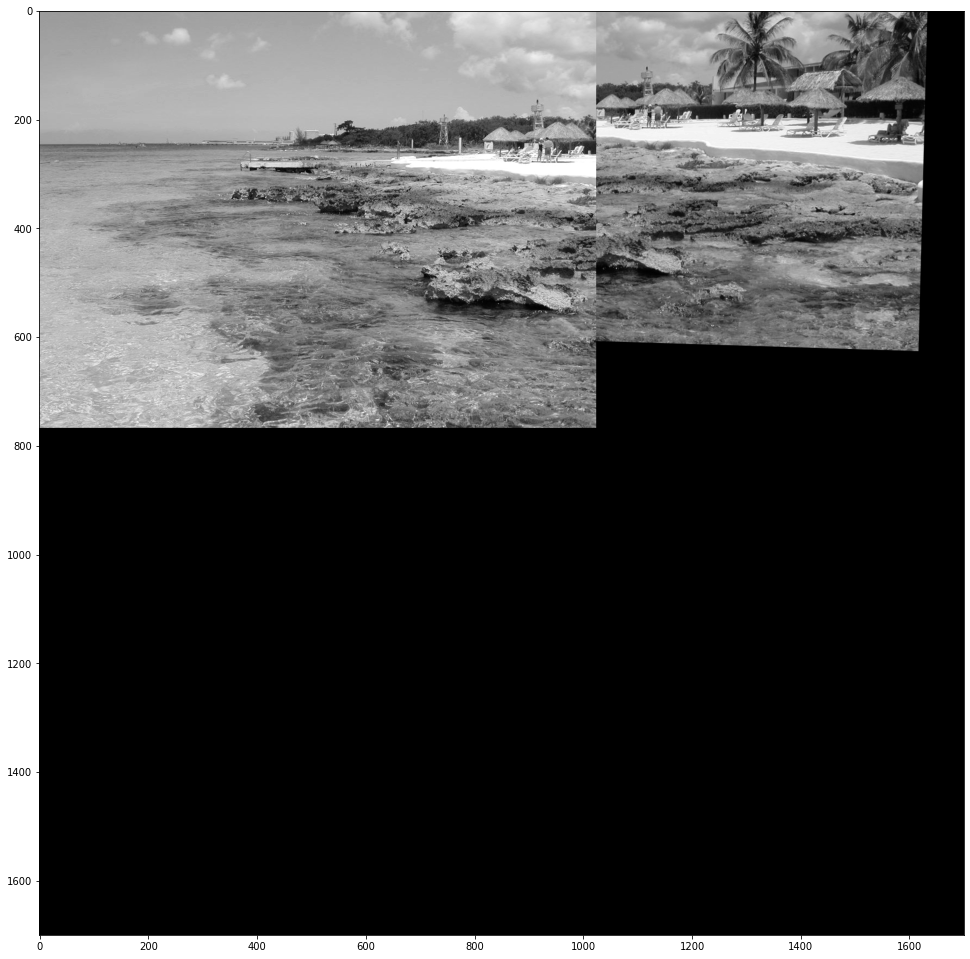

In [34]:
H, status = cv.findHomography(point_set1, point_set2, cv.RANSAC, 5.0) # computing H to transform right_image to left_image
print(H)

panorama = cv.warpPerspective(im_right, np.linalg.inv(H), (1700,1700)) # Applies a homogeneous transformation to an image.
plt.figure(figsize=(8,8))
plt.imshow(panorama, cmap='gray', vmin = 0, vmax = 255)
panorama[0:im_left.shape[0], 0:im_left.shape[1]] = im_left

plt.figure(figsize=(30,17))
plt.imshow(panorama, cmap='gray', vmin = 0, vmax = 255)
# cv.namedWindow("Panorama", cv.WINDOW_AUTOSIZE)
# cv.imshow("Panorama", panorama)
# cv.waitKey(0)
# cv.destroyAllWindows()

In [63]:
npz['keypoints0'].shape

(669, 2)

In [64]:
npz['keypoints1'].shape

(872, 2)

In [65]:
npz['matches'].shape

(669,)

In [66]:
npz['matches'][npz['matches']>-1]

array([  0,  12,  21,  27,  51,  52,  54,  53,  57,  67,  68,  61,  76,
        75,  85,  80,  90,  94, 102, 122, 126, 118, 114, 119, 124, 123,
       132, 140, 146, 135, 141, 133, 151, 148, 156, 162, 161, 168, 182,
       166, 191, 192, 177, 194, 188, 195, 214, 218, 213, 217, 233, 232,
       237, 241, 242, 253, 251, 254, 247, 256, 258, 262, 257, 270, 265,
       275, 269, 273, 285, 286, 291, 283, 292, 295, 302, 303, 297, 304,
       305, 298, 296, 307, 311, 306, 312, 316, 308, 317, 318, 320, 326,
       321, 330, 335, 331, 339, 342, 348, 357, 347, 349, 353, 350, 359,
       343, 354, 356, 364, 365, 369, 367, 376, 385, 377, 386, 382, 389,
       390, 391, 387, 393, 392, 395, 396, 397, 412, 399, 401, 402, 403,
       406, 404, 413, 408, 417, 424, 419, 422, 423, 425, 426, 427, 428,
       430, 431, 439, 435, 433, 442, 434, 436, 440, 448, 449, 450, 455,
       459, 456, 458, 461, 460, 464, 472, 471, 473, 474, 475, 480, 493,
       479, 485, 492, 498, 505, 499, 496, 497, 491, 500, 504, 50

In [67]:
npz['match_confidence'].shape

(669,)

In [24]:
np.max(npz['match_confidence'])

0.95743716

In [41]:
np.array([1,2,3])[False, True, True]

array([], shape=(0, 3), dtype=int32)

In [53]:
npz['matches'][:10]

array([-1,  0, -1, -1, -1, 12, -1, -1, -1, -1], dtype=int64)

In [52]:
npz['matches']>-1

array([False,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True,  True, False, False,  True, False, False,
       False, False, False, False, False, False,  True,  True, False,
        True,  True,  True,  True,  True, False, False,  True, False,
       False,  True, False, False,  True,  True, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False,  True,  True, False,  True,
        True,  True, False,  True, False, False, False, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False,  True, False,  True,  True,  True, False,  True,
        True, False,  True,  True, False, False, False, False,  True,
       False, False,